[View in Colaboratory](https://colab.research.google.com/github/sbanerjee2020/alt-futures/blob/master/SB_ALT_Futures.ipynb)

# Predicting ALTCoin Prices

Predicting the price of cryptos by harnessing deep learning, machine learning and artificial intelligence

# References

### Original source
1.  David Sheehan Post: [HERE](https://dashee87.github.io/deep%20learning/python/predicting-cryptocurrency-prices-with-deep-learning/)

2.  Notebook:    [HERE](# https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb)

### Related work
3.  Jakob Aungiers:  [HERE](http://www.jakob-aungiers.com/articles/a/Multidimensional-LSTM-Networks-to-Predict-Bitcoin-Price)

4. Crypto Currency Trader :  [HERE](https://ethereumprice.org/ground-breaking-metropolis-release-flying-radar/)

5. What is Metropolis:  [HERE](https://ethereumprice.org/ground-breaking-metropolis-release-flying-radar/)

### LSTM

6. Understanding LSTM: [HERE](http://colah.github.io/posts/2015-08-Understanding-LSTMs/)

7. Exploring LSTM:  [HERE](http://blog.echen.me/2017/05/30/exploring-lstms/)

8. Original LSTM Paper:  [HERE](http://www.bioinf.jku.at/publications/older/2604.pdf)

### Time Series

9. How to make a Time Series Stationery:  [HERE](https://dashee87.github.io/data%20science/general/A-Road-Incident-Model-Analysis/)

### Random Walks
10. Why Might Share prices follow Random Walk?  [HERE](https://www.tcd.ie/Economics/assets/pdf/SER/2007/Samuel_Dupernex.pdf)

### Keras
11. Keras Tutorial for Neural Network Beginners:  [HERE](https://dashee87.github.io/data%20science/deep%20learning/python/another-keras-tutorial-for-neural-network-beginners/)

In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


# Install  Packages

In [2]:
!pip install lxml
!pip install BeautifulSoup4
!pip install --upgrade pandas
!pip install pydrive
!pip install ipywidgets


    100% |████████████████████████████████| 5.6MB 199kB/s 
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: pandas in /usr/local/lib/python2.7/dist-packages
    100% |████████████████████████████████| 512kB 1.8MB/s 
    100% |████████████████████████████████| 215kB 4.0MB/s 
Requirement already up-to-date: numpy>=1.9.0 in /usr/local/lib/python2.7/dist-packages (from pandas)
Requirement already up-to-date: six>=1.5 in /usr/local/lib/python2.7/dist-packages (from python-dateutil->pandas)
  Found existing installation: pytz 2016.7
    Uninstalling pytz-2016.7:
      Successfully uninstalled pytz-2016.7
  Found existing installation: python-dateutil 2.5.3
    Uninstalling python-dateutil-2.5.3:
      Successfully uninstall

  Running setup.py bdist_wheel for pandocfilters ... - done
  Stored in directory: /content/.cache/pip/wheels/39/01/56/f1b08a6275acc59e846fa4c1e1b65dbc1919f20157d9e66c20
Successfully built pandocfilters
  Found existing installation: pandocfilters 1.3.0
    Uninstalling pandocfilters-1.3.0:
      Successfully uninstalled pandocfilters-1.3.0
You are using pip version 9.0.3, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from google.colab import files

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)




# Method

We're going to employ a Long Short Term Memory (LSTM) model; it's a particular type of deep learning model that is well suited to time series data (or any data with temporal/spatial/structural order e.g. movies, sentences, etc.). 

If you wish to truly understand the underlying theory (what kind of crypto enthusiast are you?), then I'd recommend [this blog](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) or [this blog](http://blog.echen.me/2017/05/30/exploring-lstms/) or the [original (white)paper](http://www.bioinf.jku.at/publications/older/2604.pdf). 

# Data


There's a [dataset on Kaggle](https://www.kaggle.com/mczielinski/bitcoin-historical-data) that details minute by minute Bitcoin prices (plus some other factors) for the last few years (featured on that [other blog post](http://www.jakob-aungiers.com/articles/a/Multidimensional-LSTM-Networks-to-Predict-Bitcoin-Price)). Over this timescale, noise could overwhelm the signal, so we'll opt for daily prices. 

The issue here is that we may have not sufficient data (we'll have hundreds of rows rather than thousands or millions). In deep learning, no model can overcome a severe lack of data. I also don't want to rely on static files, as that'll complicate the process of updating the model in the future with new data. Instead, we'll aim to pull data from websites and APIs.

As we'll be combining multiple cryptos in one model, it's probably a good idea to pull the data from one source. We'll use [coinmarketcap.com](https://coinmarketcap.com). For now, we'll only consider Bitcoin and Ether, but it wouldn't be hard to add the [IOTA](https://coinmarketcap.com/currencies/iota/) using this approach. Before we import the data, we must load some python packages that will make our lives so much easier.

In [5]:
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import numpy as np

# get market info for bitcoin from the start of 2016 to the current day
bitcoin_market_info = pd.read_html("https://coinmarketcap.com/currencies/bitcoin/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
bitcoin_market_info = bitcoin_market_info.assign(Date=pd.to_datetime(bitcoin_market_info['Date']))
# when Volume is equal to '-' convert it to 0
bitcoin_market_info.loc[bitcoin_market_info['Volume']=="-",'Volume']=0
# convert to int
bitcoin_market_info['Volume'] = bitcoin_market_info['Volume'].astype('int64')
# look at the first few rows
bitcoin_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-04-18,7944.43,8197.80,7886.01,8163.42,6529910000,134926000000
1,2018-04-17,8071.66,8285.96,7881.72,7902.09,6900880000,137070000000
2,2018-04-16,8337.57,8371.15,7925.73,8058.67,5631310000,141571000000
3,2018-04-15,7999.33,8338.42,7999.33,8329.11,5244480000,135812000000
4,2018-04-14,7874.67,8140.71,7846.00,7986.24,5191430000,133682000000


In [0]:
from pylab import rcParams
rcParams['figure.figsize'] = 12, 6

In [7]:
# get market info for ethereum from the start of 2016 to the current day
eth_market_info = pd.read_html("https://coinmarketcap.com/currencies/ethereum/historical-data/?start=20130428&end="+time.strftime("%Y%m%d"))[0]
# convert the date string to the correct date format
eth_market_info = eth_market_info.assign(Date=pd.to_datetime(eth_market_info['Date']))
# look at the first few rows
eth_market_info.head()

,Date,Open,High,Low,Close,Volume,Market Cap
0,2018-04-18,503.31,525.09,503.05,524.79,1762940000,49769600000
1,2018-04-17,511.14,518.03,502.56,502.89,1760360000,50534000000
2,2018-04-16,532.07,534.20,500.25,511.15,1758980000,52592200000
3,2018-04-15,502.88,531.70,502.88,531.70,1726090000,49696300000
4,2018-04-14,492.58,512.02,488.28,501.48,1519080000,48668400000


We loaded some python packages and then imported the table that you see on [this site](https://coinmarketcap.com/currencies/bitcoin/historical-data/). With a little bit of data cleaning, we arrive at the above table. We also do the same thing for ether by simply replacing 'bitcoin' with 'ethereum' in the url.

Next, we plot the price and volume of both cryptos over time.

In [8]:
#  Getting Python Version
import sys
from PIL import Image
import io
sys.version_info[0]

2

In [0]:
# Getting the Bitcoin and Eth logos

if sys.version_info[0] < 3:
    import urllib2 as urllib
    bt_img = urllib.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
    eth_img = urllib.urlopen("https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Ethereum_logo_2014.svg/256px-Ethereum_logo_2014.svg.png")
else:
    import urllib
    bt_img = urllib.request.urlopen("http://logok.org/wp-content/uploads/2016/10/Bitcoin-Logo-640x480.png")
    eth_img = urllib.request.urlopen("https://upload.wikimedia.org/wikipedia/commons/thumb/0/05/Ethereum_logo_2014.svg/256px-Ethereum_logo_2014.svg.png")

image_file = io.BytesIO(bt_img.read())
bitcoin_im = Image.open(image_file)

image_file = io.BytesIO(eth_img.read())
eth_im = Image.open(image_file)
width_eth_im , height_eth_im  = eth_im.size
eth_im = eth_im.resize((int(eth_im.size[0]*0.4), int(eth_im.size[1]*0.4)), Image.ANTIALIAS)
bitcoin_im = bitcoin_im.resize((int(bitcoin_im.size[0]*0.4), int(bitcoin_im.size[1]*0.4)), Image.ANTIALIAS)

In [0]:
#bitcoin_im

In [0]:
#eth_im

In [0]:
bitcoin_market_info.columns =[bitcoin_market_info.columns[0]]+['bt_'+i for i in bitcoin_market_info.columns[1:]]
eth_market_info.columns =[eth_market_info.columns[0]]+['eth_'+i for i in eth_market_info.columns[1:]]

#  Visualize

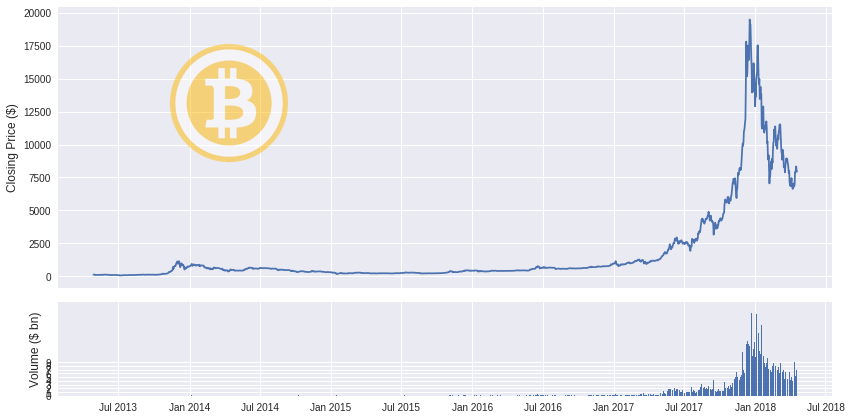

In [12]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax2.set_ylabel('Volume ($ bn)',fontsize=12)
ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(bitcoin_market_info['Date'].astype(datetime.datetime),bitcoin_market_info['bt_Open'])
ax2.bar(bitcoin_market_info['Date'].astype(datetime.datetime).values, bitcoin_market_info['bt_Volume'].values)
fig.tight_layout()
fig.figimage(bitcoin_im, 100, 220, zorder=3,alpha=.5)
plt.show()

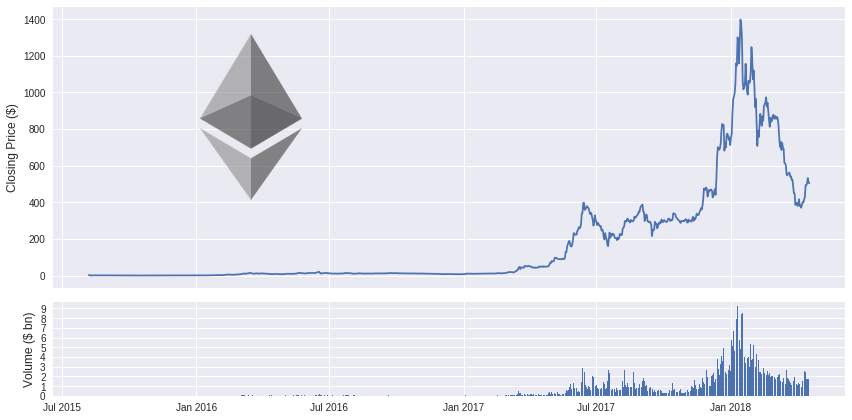

In [13]:
fig, (ax1, ax2) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[3, 1]})
#ax1.set_yscale('log')
ax1.set_ylabel('Closing Price ($)',fontsize=12)
ax2.set_ylabel('Volume ($ bn)',fontsize=12)
ax2.set_yticks([int('%d000000000'%i) for i in range(10)])
ax2.set_yticklabels(range(10))
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(eth_market_info['Date'].astype(datetime.datetime),eth_market_info['eth_Open'])
ax2.bar(eth_market_info['Date'].astype(datetime.datetime).values, eth_market_info['eth_Volume'].values)
fig.tight_layout()
fig.figimage(eth_im, 200, 220, zorder=3, alpha=.6)
plt.show()

# Merge  BTC and ETH
Add New column:  day_diff  =   (Close  - Open)  /  Open

In [14]:
market_info = pd.merge(bitcoin_market_info,eth_market_info, on=['Date'])
market_info = market_info[market_info['Date']>='2016-01-01']
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'day_diff': lambda x: (x[coins+'Close']-x[coins+'Open'])/x[coins+'Open']}
    market_info = market_info.assign(**kwargs)
market_info.head()

,Date,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,eth_Market Cap,bt_day_diff,eth_day_diff
0,2018-04-18,7944.43,8197.80,7886.01,8163.42,6529910000,134926000000,503.31,525.09,503.05,524.79,1762940000,49769600000,0.027565,0.042677
1,2018-04-17,8071.66,8285.96,7881.72,7902.09,6900880000,137070000000,511.14,518.03,502.56,502.89,1760360000,50534000000,-0.021008,-0.016140
2,2018-04-16,8337.57,8371.15,7925.73,8058.67,5631310000,141571000000,532.07,534.20,500.25,511.15,1758980000,52592200000,-0.033451,-0.039318
3,2018-04-15,7999.33,8338.42,7999.33,8329.11,5244480000,135812000000,502.88,531.70,502.88,531.70,1726090000,49696300000,0.041226,0.057310
4,2018-04-14,7874.67,8140.71,7846.00,7986.24,5191430000,133682000000,492.58,512.02,488.28,501.48,1519080000,48668400000,0.014168,0.018068


In [25]:
market_info.columns.values.tolist()

[u'Date',
 u'bt_Open',
 u'bt_High',
 u'bt_Low',
 u'bt_Close',
 u'bt_Volume',
 u'bt_Market Cap',
 u'eth_Open',
 u'eth_High',
 u'eth_Low',
 u'eth_Close',
 u'eth_Volume',
 u'eth_Market Cap',
 'bt_day_diff',
 'eth_day_diff']

In [23]:
market_info.describe()

,bt_Open,bt_High,bt_Low,bt_Close,bt_Volume,bt_Market Cap,eth_Open,eth_High,eth_Low,eth_Close,eth_Volume,bt_day_diff,eth_day_diff
count,839.000000,839.000000,839.000000,839.000000,8.390000e+02,8.390000e+02,839.000000,839.000000,839.000000,839.000000,8.390000e+02,839.000000,839.000000
mean,3273.682408,3398.853087,3134.850679,3282.258558,2.189781e+09,5.444793e+10,203.601137,213.010003,193.241082,204.136564,7.214096e+08,0.004191,0.009530
std,4155.624034,4346.632013,3917.623968,4157.241215,3.977915e+09,7.002460e+10,293.617157,307.996248,276.717634,293.575172,1.304948e+09,0.042320,0.069758
min,365.070000,374.950000,354.910000,364.330000,2.851400e+07,5.507790e+09,0.933712,0.954822,0.929835,0.937124,2.060620e+05,-0.185897,-0.271176
25%,607.110000,609.950000,604.730000,607.060000,7.489110e+07,9.631545e+09,10.815000,11.150000,10.460000,10.820000,1.251560e+07,-0.009156,-0.023725
50%,1044.580000,1063.030000,1026.640000,1046.210000,2.423430e+08,1.696020e+10,15.450000,16.060000,14.340000,15.740000,5.375750e+07,0.002879,0.000000
75%,4343.075000,4422.215000,4234.175000,4361.605000,1.992055e+09,7.192895e+10,304.430000,313.440000,295.345000,305.400000,9.366895e+08,0.019609,0.035503
max,19475.800000,20089.000000,18974.100000,19497.400000,2.384090e+10,3.261410e+11,1397.480000,1432.880000,1290.600000,1396.420000,9.214950e+09,0.254702,0.335556


# Training and Test Sets


We have some data, so now we need to build a model. In deep learning, the data is typically split into training and test sets. The model is built on the training set and subsequently evaluated on the unseen test set. In time series models, we generally train on one period of time and then test on another separate period. Rather arbitrarily, I'll set the cut-off date to June 1st 2017 (i.e. model will be trained on data before that date and assessed on data after it).

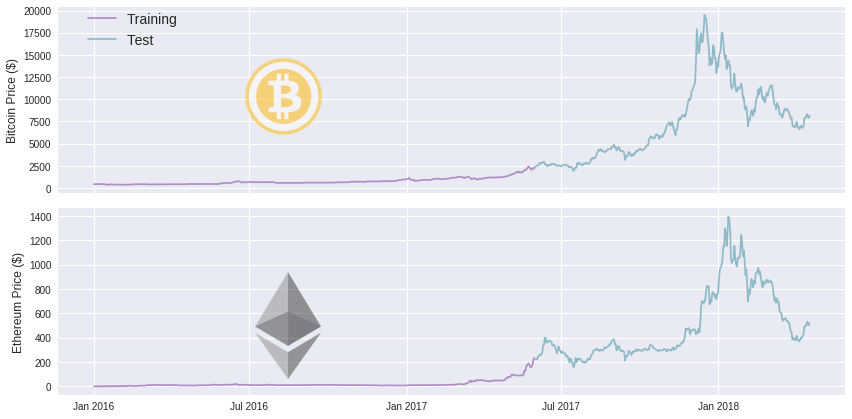

In [26]:
split_date = '2017-06-01'
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,7]])
ax2.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,7]])
ax1.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['bt_Close'], 
         color='#B08FC7', label='Training')
ax1.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['bt_Close'], 
         color='#8FBAC8', label='Test')
ax2.plot(market_info[market_info['Date'] < split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] < split_date]['eth_Close'], 
         color='#B08FC7')
ax2.plot(market_info[market_info['Date'] >= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date'] >= split_date]['eth_Close'], color='#8FBAC8')
ax1.set_xticklabels('')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
plt.tight_layout()
ax1.legend(bbox_to_anchor=(0.03, 1), loc=2, borderaxespad=0., prop={'size': 14})
fig.figimage(bitcoin_im.resize((int(bitcoin_im.size[0]*0.65), int(bitcoin_im.size[1]*0.65)), Image.ANTIALIAS), 
             200, 260, zorder=3,alpha=.5)
fig.figimage(eth_im.resize((int(eth_im.size[0]*0.65), int(eth_im.size[1]*0.65)), Image.ANTIALIAS), 
             255, 40, zorder=3,alpha=.5)
plt.show()

# Lag model

You can see that the training period mostly consists of periods when cryptos were relatively cheaper. As such, the training data may not be representative of the test data, undermining the model's ability to generalise to unseen data (you could try to make your data stationary- discussed [here](https://dashee87.github.io/data%20science/general/A-Road-Incident-Model-Analysis/)). But why let negative realities get in the way of baseless optimism? Before we take our deep artificially intelligent machine learning model to the moon, it's worth discussing a simpler model. The most basic model is to set tomorrow's price equal to today's price (which we'll crudely call a lag model). This is how we'd define such a model in mathematical terms:

\begin{align}
PredPrice_{t} & = ActualPrice_{t-1}
\end{align}

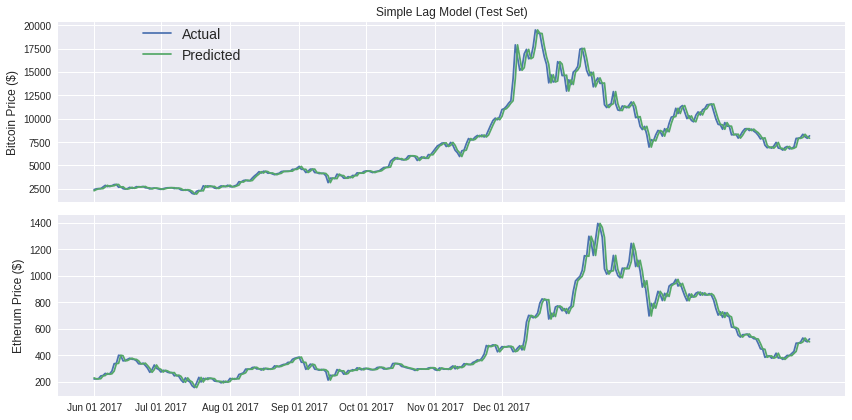

In [27]:
# trivial lag model: P_t = P_(t-1)
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['bt_Close'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['bt_Close'][1:].values, label='Predicted')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.set_title('Simple Lag Model (Test Set)')
ax2.set_ylabel('Etherum Price ($)',fontsize=12)
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[market_info['Date']>= datetime.datetime.strptime(split_date, '%Y-%m-%d') - 
                      datetime.timedelta(days=1)]['eth_Close'][1:].values, label='Predicted')
fig.tight_layout()
plt.show()

Extending this trivial lag model, [stock prices are commonly treated as random walks](https://www.tcd.ie/Economics/assets/pdf/SER/2007/Samuel_Dupernex.pdf), which can be defined in these mathematical terms:

\begin{align}
PredPrice_{t} & = ActualPrice_{t-1} * \epsilon, \epsilon \sim N(\mu, \sigma)
\end{align}

We'll determine &mu; and &sigma; from the training sets and apply the random walk model to the Bitcoin and Ethereum test sets.

First, we may want to make sure the daily change in price follows a normal distribution. We'll plot the histogram of values.

# Distribution of Volatility

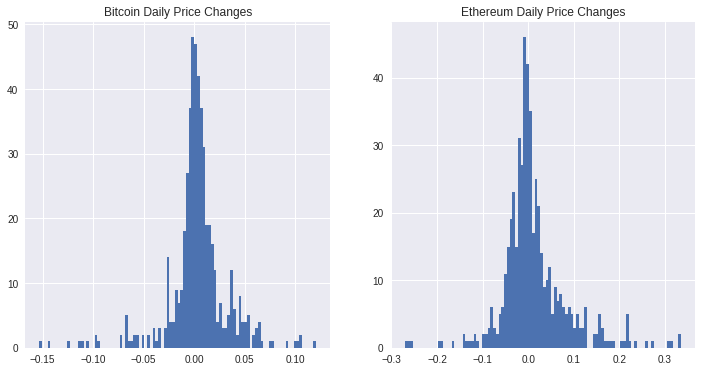

In [28]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.hist(market_info[market_info['Date']< split_date]['bt_day_diff'].values, bins=100)
ax2.hist(market_info[market_info['Date']< split_date]['eth_day_diff'].values, bins=100)
ax1.set_title('Bitcoin Daily Price Changes')
ax2.set_title('Ethereum Daily Price Changes')
plt.show()

# Single Point Random Walk

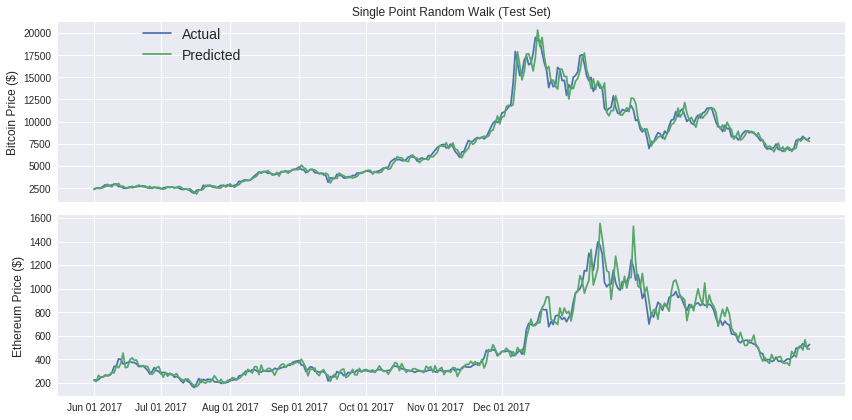

In [29]:
np.random.seed(202)
bt_r_walk_mean, bt_r_walk_sd = np.mean(market_info[market_info['Date']< split_date]['bt_day_diff'].values), \
                         np.std(market_info[market_info['Date']< split_date]['bt_day_diff'].values)
bt_random_steps = np.random.normal(bt_r_walk_mean, bt_r_walk_sd, 
                (max(market_info['Date']).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)
eth_r_walk_mean, eth_r_walk_sd = np.mean(market_info[market_info['Date']< split_date]['eth_day_diff'].values), \
                         np.std(market_info[market_info['Date']< split_date]['eth_day_diff'].values)
eth_random_steps = np.random.normal(eth_r_walk_mean, eth_r_walk_sd, 
                (max(market_info['Date']).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
     market_info[market_info['Date']>= split_date]['bt_Close'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
      market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['bt_Close'].values[1:] * 
     (1+bt_random_steps), label='Predicted')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
     market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
      market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['eth_Close'].values[1:] * 
     (1+eth_random_steps), label='Predicted')
ax1.set_title('Single Point Random Walk (Test Set)')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.tight_layout()
plt.show()

Wow! Look at those prediction lines. Apart from a few kinks, it broadly tracks the actual closing price for each coin. It even captures the eth rises (and subsequent falls) in mid-June and late August. As pointed out on that other blog, models that only make predictions one point into the future are often misleadingly accurate, as errors aren't carried over to subsequent predictions. No matter how large the error, it's essentially reset at each time point, as the model is fed the true price. The Bitcoin random walk is particularly deceptive, as the scale of the y-axis is quite wide, making the prediction line appear quite smooth.

Single point predictions are unfortunately quite common when evaluating time series models (e.g.[here](https://medium.com/@binsumi/neural-networks-and-bitcoin-d452bfd7757e) and [here](https://blog.statsbot.co/time-series-prediction-using-recurrent-neural-networks-lstms-807fa6ca7f)). A better idea could be to measure its accuracy on multi-point predictions. That way, errors from previous predictions aren't reset but rather are compounded by subsequent predictions. Thus, poor models are penalised more heavily. In mathematical terms:

\begin{align}
PredPrice_{t} & = PredPrice_{t-1} * \epsilon, \epsilon \sim N(\mu, \sigma)\ \&  \ PredPrice_0 = Price_0
\end{align}

Let's get our random walk model to predict the closing prices over the total test set.

# Full Interval Random Walk

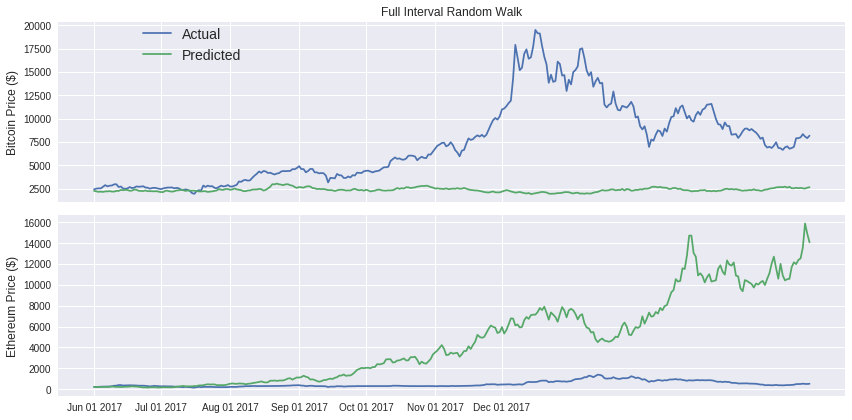

In [30]:
bt_random_walk = []
eth_random_walk = []
for n_step, (bt_step, eth_step) in enumerate(zip(bt_random_steps, eth_random_steps)):
    if n_step==0:
        bt_random_walk.append(market_info[market_info['Date']< split_date]['bt_Close'].values[0] * (bt_step+1))
        eth_random_walk.append(market_info[market_info['Date']< split_date]['eth_Close'].values[0] * (eth_step+1))
    else:
        bt_random_walk.append(bt_random_walk[n_step-1] * (bt_step+1))
        eth_random_walk.append(eth_random_walk[n_step-1] * (eth_step+1))
fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels('')
ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['bt_Close'].values, label='Actual')
ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         bt_random_walk[::-1], label='Predicted')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         eth_random_walk[::-1], label='Predicted')

ax1.set_title('Full Interval Random Walk')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.tight_layout()
plt.show()

The model predictions are extremely sensitive to the random seed. I've selected one where the full interval random walk looks almost decent for Ethereum. In the [accompanying Jupyter notebook](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb), you can interactively play around with the seed value below to see how badly it can perform.

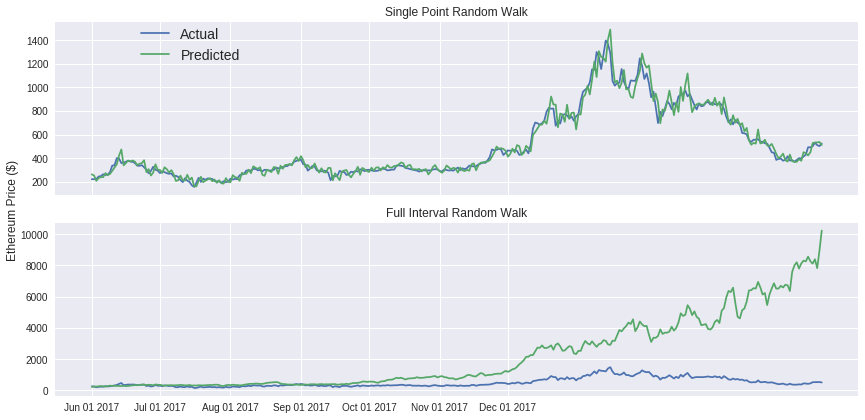

<function __main__.plot_func>

In [31]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

def plot_func(freq):
    np.random.seed(freq)
    random_steps = np.random.normal(eth_r_walk_mean, eth_r_walk_sd, 
                (max(market_info['Date']).to_pydatetime() - datetime.datetime.strptime(split_date, '%Y-%m-%d')).days + 1)
    random_walk = []
    for n_step,i in enumerate(random_steps):
        if n_step==0:
            random_walk.append(market_info[market_info['Date']< split_date]['eth_Close'].values[0] * (i+1))
        else:
            random_walk.append(random_walk[n_step-1] * (i+1))
    fig, (ax1, ax2) = plt.subplots(2,1)
    ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
    ax1.set_xticklabels('')
    ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
    ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
    ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
         market_info[market_info['Date']>= split_date]['eth_Close'].values, label='Actual')
    ax1.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['eth_Close'].values[1:] * 
         (1+random_steps), label='Predicted')
    ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
          market_info[(market_info['Date']+ datetime.timedelta(days=1))>= split_date]['eth_Close'].values[1:] * 
         (1+random_steps))
    ax2.plot(market_info[market_info['Date']>= split_date]['Date'].astype(datetime.datetime),
             random_walk[::-1])
    ax1.set_title('Single Point Random Walk')
    ax1.set_ylabel('')
    # for static figures, you may wish to insert the random seed value
#    ax1.annotate('Random Seed: %d'%freq, xy=(0.75, 0.2),  xycoords='axes fraction',
#            xytext=(0.75, 0.2), textcoords='axes fraction')
    ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
    ax2.set_title('Full Interval Random Walk')
    fig.text(0.0, 0.5, 'Ethereum Price ($)', va='center', rotation='vertical',fontsize=12)
    plt.tight_layout()
#    plt.savefig('image%d.png'%freq, bbox_inches='tight')
    plt.show()
    
interact(plot_func, freq =widgets.IntSlider(min=200,max=210,step=1,value=205, description='Random Seed:'))

Notice how the single point random walk always looks quite accurate, even though there's no real substance behind it. Hopefully, you'll be more suspicious of any blog that claims to accurately predict prices. I probably shouldn't worry; it's not like crypto fans to be seduced by [slick marketing claims](https://uetoken.com/).

# Long Short Term Memory (LSTM)
### Keras

We will use Keras, as it is most intuitive for non-experts. 

In [0]:
for coins in ['bt_', 'eth_']: 
    kwargs = { coins+'close_off_high': lambda x: 2*(x[coins+'High']- x[coins+'Close'])/(x[coins+'High']-x[coins+'Low'])-1,
            coins+'volatility': lambda x: (x[coins+'High']- x[coins+'Low'])/(x[coins+'Open'])}
    market_info = market_info.assign(**kwargs)

In [34]:
model_data = market_info[['Date']+[coin+metric for coin in ['bt_', 'eth_'] 
                                   for metric in ['Close','Volume','close_off_high','volatility']]]
# need to reverse the data frame so that subsequent rows represent later timepoints
model_data = model_data.sort_values(by='Date')
model_data.head()

,Date,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
838,2016-01-01,434.33,36278900,-0.560641,0.020292,0.948024,206062,-0.418477,0.025040
837,2016-01-02,433.44,30096600,0.250597,0.009641,0.937124,255504,0.965898,0.034913
836,2016-01-03,430.01,39633800,-0.173865,0.020827,0.971905,407632,-0.317885,0.060792
835,2016-01-04,433.09,38477500,-0.474265,0.012649,0.954480,346245,-0.057657,0.047943
834,2016-01-05,431.96,34522600,-0.013333,0.010391,0.950176,219833,0.697930,0.025236


I've created a new data frame called `model_data`. I've removed some of the previous columns (open price, daily highs and lows) and reformulated some new ones. `close_off_high` represents the gap between the closing price and price high for that day, where values of -1 and 1 mean the closing price was equal to the daily low or daily high, respectively. The `volatility` columns are simply the difference between high and low price divided by the opening price. You may also notice that `model_data` is arranged in order of earliest to latest. We don't actually need the date column anymore, as that information won't be fed into the model.

Our LSTM model will use previous data (both bitcoin and eth) to predict the next day's closing price of a specific coin. We must decide how many previous days it will have access to. Again, it's rather arbitrary, but I'll opt for 10 days, as it's a nice round number. We build little data frames consisting of 10 consecutive days of data (called windows), so the first window will consist of the 0-9th rows of the training set (Python is zero-indexed), the second will be the rows 1-10, etc.  Picking a small window size means we can feed more windows into our model; the downside is that the model may not have sufficient information to detect complex long term behaviours (if such things exist). 

Deep learning models don't like inputs that vary wildly. Looking at those columns, some values range between -1 and 1, while others are on the scale of millions. We need to normalise the data, so that our inputs are somewhat consistent. Typically, you want values between -1 and 1. The `off_high` and `volatility` columns are fine as they are. For the remaining columns, like that [other blog post](http://www.jakob-aungiers.com/articles/a/Multidimensional-LSTM-Networks-to-Predict-Bitcoin-Price), we'll normalise the inputs to the first value in the window.

In [0]:
# we don't need the date columns anymore
training_set, test_set = model_data[model_data['Date']<split_date], model_data[model_data['Date']>=split_date]
training_set = training_set.drop('Date', 1)
test_set = test_set.drop('Date', 1)

In [0]:
window_len = 10
norm_cols = [coin+metric for coin in ['bt_', 'eth_'] for metric in ['Close','Volume']]

In [0]:
LSTM_training_inputs = []
for i in range(len(training_set)-window_len):
    temp_set = training_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_training_inputs.append(temp_set)
LSTM_training_outputs = (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1

In [0]:
LSTM_test_inputs = []
for i in range(len(test_set)-window_len):
    temp_set = test_set[i:(i+window_len)].copy()
    for col in norm_cols:
        temp_set.loc[:, col] = temp_set[col]/temp_set[col].iloc[0] - 1
    LSTM_test_inputs.append(temp_set)
LSTM_test_outputs = (test_set['eth_Close'][window_len:].values/test_set['eth_Close'][:-window_len].values)-1

In [39]:
LSTM_training_inputs[0]

,bt_Close,bt_Volume,bt_close_off_high,bt_volatility,eth_Close,eth_Volume,eth_close_off_high,eth_volatility
838,0.000000,0.000000,-0.560641,0.020292,0.000000,0.000000,-0.418477,0.025040
837,-0.002049,-0.170410,0.250597,0.009641,-0.011498,0.239937,0.965898,0.034913
836,-0.009946,0.092475,-0.173865,0.020827,0.025190,0.978201,-0.317885,0.060792
835,-0.002855,0.060603,-0.474265,0.012649,0.006810,0.680295,-0.057657,0.047943
834,-0.005457,-0.048411,-0.013333,0.010391,0.002270,0.066829,0.697930,0.025236
833,-0.012019,-0.061645,-0.003623,0.012782,0.002991,0.498534,-0.214540,0.026263
832,0.054613,1.413585,-0.951499,0.069045,-0.006349,2.142074,0.681644,0.040587
831,0.043515,0.570968,0.294196,0.032762,0.040890,1.647747,-0.806717,0.055274
830,0.030576,-0.110282,0.814194,0.017094,0.040937,0.098121,-0.411897,0.019021
829,0.031451,-0.007801,-0.919598,0.017758,0.054014,0.896944,-0.938235,0.025266


This table represents an example of our LSTM model input (we'll actually have hundreds of similar tables). We've normalised some columns so that their values are equal to 0 in the first time point, so we're aiming to predict changes in price relative to this timepoint. We're now ready to build the LSTM model. This is actually quite straightforward with Keras, you simply stack componenets on top of each other (better explained [here](https://dashee87.github.io/data%20science/deep%20learning/python/another-keras-tutorial-for-neural-network-beginners/)).

In [0]:
# I find it easier to work with numpy arrays rather than pandas dataframes
# especially as we now only have numerical data
LSTM_training_inputs = [np.array(LSTM_training_input) for LSTM_training_input in LSTM_training_inputs]
LSTM_training_inputs = np.array(LSTM_training_inputs)

LSTM_test_inputs = [np.array(LSTM_test_inputs) for LSTM_test_inputs in LSTM_test_inputs]
LSTM_test_inputs = np.array(LSTM_test_inputs)

In [0]:
# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

def build_model(inputs, output_size, neurons, activ_func="linear",
                dropout=0.25, loss="mae", optimizer="adam"):
    model = Sequential()

    model.add(LSTM(neurons, input_shape=(inputs.shape[1], inputs.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

So, the `build_model` functions constructs an empty model unimaginatively called model (`model = Sequential`), to which an LSTM layer is added. That layer has been shaped to fit our inputs (n x m tables, where n and m represent the number of timepoints/rows and columns, respectively). The function also includes more generic neural network features, like [dropout](https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/) and [activation functions](https://dashee87.github.io/data%20science/deep%20learning/visualising-activation-functions-in-neural-networks/). Now, we just need to specify the number of neurons to place in the LSTM layer (I've opted for 20 to keep runtime reasonable), as well as the data on which the model will be trained.

In [44]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# model output is next price normalised to 10th previous closing price
LSTM_training_outputs = (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs, LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 4s - loss: 0.1648
Epoch 2/50
 - 4s - loss: 0.1117
Epoch 3/50
 - 4s - loss: 0.1064
Epoch 4/50
 - 4s - loss: 0.0952
Epoch 5/50
 - 4s - loss: 0.0870
Epoch 6/50
 - 4s - loss: 0.0848
Epoch 7/50
 - 4s - loss: 0.0835
Epoch 8/50
 - 4s - loss: 0.0801
Epoch 9/50
 - 4s - loss: 0.0788
Epoch 10/50
 - 4s - loss: 0.0784
Epoch 11/50
 - 4s - loss: 0.0752
Epoch 12/50
 - 4s - loss: 0.0743
Epoch 13/50
 - 4s - loss: 0.0740
Epoch 14/50
 - 4s - loss: 0.0690
Epoch 15/50
 - 4s - loss: 0.0675
Epoch 16/50
 - 4s - loss: 0.0691
Epoch 17/50
 - 4s - loss: 0.0746
Epoch 18/50
 - 4s - loss: 0.0681
Epoch 19/50
 - 4s - loss: 0.0709
Epoch 20/50
 - 4s - loss: 0.0697
Epoch 21/50
 - 4s - loss: 0.0687
Epoch 22/50
 - 4s - loss: 0.0704
Epoch 23/50
 - 4s - loss: 0.0667
Epoch 24/50
 - 4s - loss: 0.0679
Epoch 25/50
 - 3s - loss: 0.0681
Epoch 26/50
 - 4s - loss: 0.0657
Epoch 27/50
 - 4s - loss: 0.0664
Epoch 28/50
 - 4s - loss: 0.0646
Epoch 29/50
 - 4s - loss: 0.0690
Epoch 30/50
 - 4s - loss: 0.0688
Epoch 31/50
 - 4s -

# Training Error
If everything went to plan, then we'd expect the training error to have gradually decreased over time.

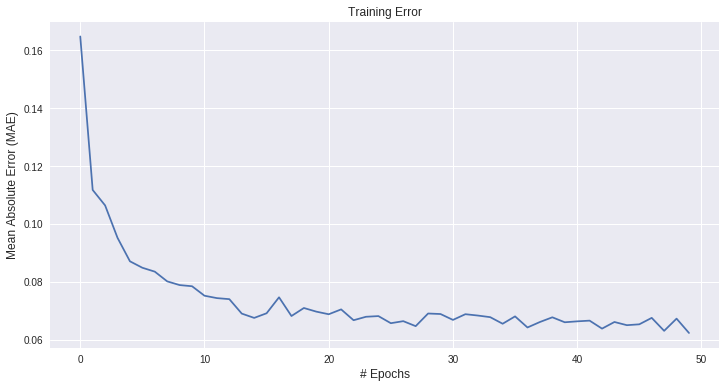

In [45]:
fig, ax1 = plt.subplots(1,1)

ax1.plot(eth_history.epoch, eth_history.history['loss'])
ax1.set_title('Training Error')

if eth_model.loss == 'mae':
    ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
# just in case you decided to change the model loss calculation
else:
    ax1.set_ylabel('Model Loss',fontsize=12)
ax1.set_xlabel('# Epochs',fontsize=12)
plt.show()

# Evaluate 
We've just built an LSTM model to predict tomorrow's Ethereum closing price. Let's see how well it performs. We start by examining its performance on the training set (data before June 2017). That number below the code represents the model's mean absolute error (mae) on the training set after the 50th training iteration (or epoch). Instead of relative changes, we can view the model output as daily closing prices.

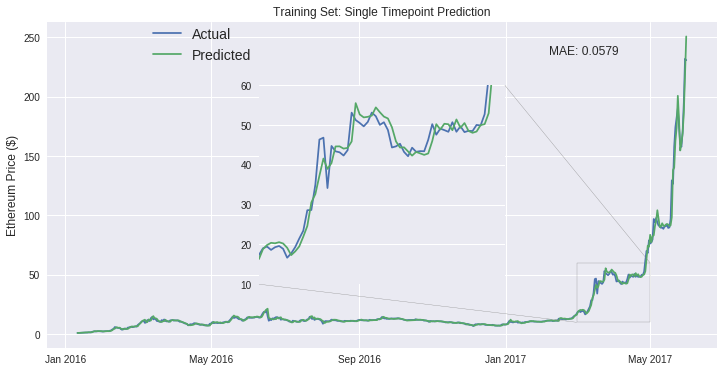

In [46]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['eth_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.15, 1), loc=2, borderaxespad=0., prop={'size': 14})
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_training_inputs))+1)-\
            (training_set['eth_Close'].values[window_len:])/(training_set['eth_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 3.35, loc=10) # zoom-factor: 3.35, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['eth_Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_training_inputs))+1) * training_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 3, 1), datetime.date(2017, 5, 1)])
axins.set_ylim([10,60])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

We shouldn't be too surprised by its apparent accuracy here. The model could access the source of its error and adjust itself accordingly. In fact, it's not hard to attain almost zero training errors. We could just cram in hundreds of neurons and train for thousands of epochs (a process known as overfitting, where you're essentially predicting noise- I included the `Dropout()` call in the `build_model` function to mitigate this risk for our relatively small model). We should be more interested in its performance on the test dataset, as this represents completely new data for the model.

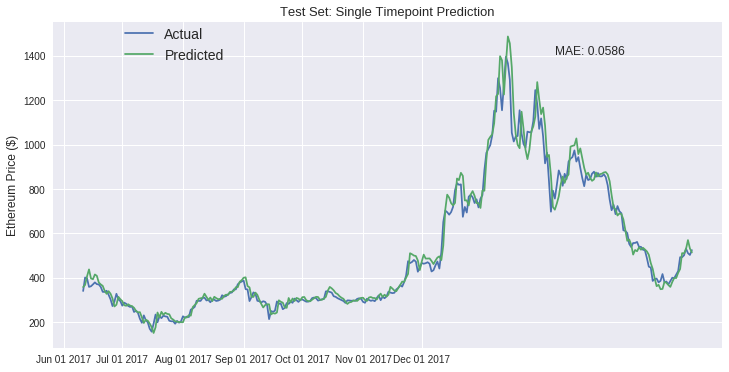

In [47]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['eth_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(eth_model.predict(LSTM_test_inputs))+1) * test_set['eth_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(eth_model.predict(LSTM_test_inputs))+1)-\
            (test_set['eth_Close'].values[window_len:])/(test_set['eth_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

Caveats aside about the misleading nature of single point predictions, our LSTM model *seems* to have performed well on the unseen test set. The most obvious flaw is that it fails to detect the inevitable downturn when the eth price suddenly shoots up (e.g mid-June and October). In fact, this is a persistent failure; it's just more apparent at these spikes. The predicted price regularly seems equivalent to the actual price just shifted one day later (e.g. the drop in mid-July). Furthermore, the model seems to be systemically overestimating the future value of Ether (join the club, right?), as the predicted line near always runs higher than the actual line. I suspect this is because the training data represents a period during which the price of Ether rose astronomically, so it expects that trend to continue (don't we all). We can also build a similar LSTM model for Bitcoin- test set predictions are plotted below (see [Jupyter notebook for full code](https://github.com/dashee87/blogScripts/blob/master/Jupyter/2017-11-20-predicting-cryptocurrency-prices-with-deep-learning.ipynb)).

In [48]:
# random seed for reproducibility
np.random.seed(202)
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs, 
                            (training_set['bt_Close'][window_len:].values/training_set['bt_Close'][:-window_len].values)-1, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)
# #eth_model.save('eth_model%d.h5'%j)

Epoch 1/50
 - 5s - loss: 0.1007
Epoch 2/50
 - 4s - loss: 0.0630
Epoch 3/50
 - 4s - loss: 0.0451
Epoch 4/50
 - 4s - loss: 0.0426
Epoch 5/50
 - 4s - loss: 0.0375
Epoch 6/50
 - 4s - loss: 0.0333
Epoch 7/50
 - 4s - loss: 0.0300
Epoch 8/50
 - 4s - loss: 0.0321
Epoch 9/50
 - 4s - loss: 0.0312
Epoch 10/50
 - 4s - loss: 0.0293
Epoch 11/50
 - 4s - loss: 0.0273
Epoch 12/50
 - 4s - loss: 0.0288
Epoch 13/50
 - 4s - loss: 0.0272
Epoch 14/50
 - 4s - loss: 0.0278
Epoch 15/50
 - 4s - loss: 0.0277
Epoch 16/50
 - 4s - loss: 0.0272
Epoch 17/50
 - 4s - loss: 0.0263
Epoch 18/50
 - 4s - loss: 0.0260
Epoch 19/50
 - 4s - loss: 0.0257
Epoch 20/50
 - 4s - loss: 0.0258
Epoch 21/50
 - 4s - loss: 0.0242
Epoch 22/50
 - 4s - loss: 0.0244
Epoch 23/50
 - 4s - loss: 0.0246
Epoch 24/50
 - 4s - loss: 0.0256
Epoch 25/50
 - 4s - loss: 0.0236
Epoch 26/50
 - 4s - loss: 0.0251
Epoch 27/50
 - 4s - loss: 0.0241
Epoch 28/50
 - 4s - loss: 0.0236
Epoch 29/50
 - 4s - loss: 0.0248
Epoch 30/50
 - 4s - loss: 0.0244
Epoch 31/50
 - 4s -

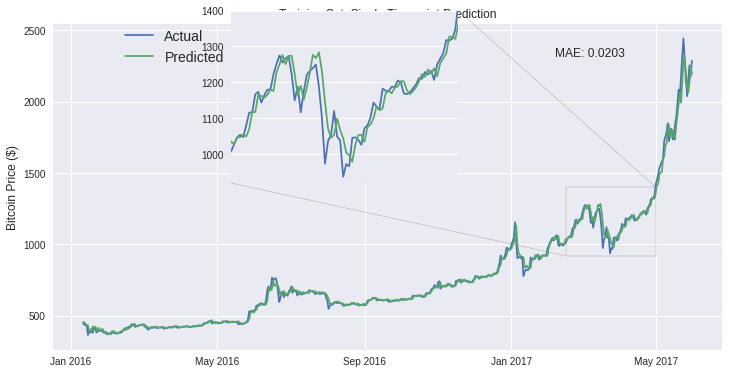

In [49]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
ax1.set_xticklabels([datetime.date(i,j,1).strftime('%b %Y')  for i in range(2013,2019) for j in [1,5,9]])
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['bt_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.set_title('Training Set: Single Timepoint Prediction')
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_training_inputs))+1)-\
            (training_set['bt_Close'].values[window_len:])/(training_set['bt_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
# figure inset code taken from http://akuederle.com/matplotlib-zoomed-up-inset
axins = zoomed_inset_axes(ax1, 2.52, loc=10, bbox_to_anchor=(400, 307)) # zoom-factor: 2.52, location: centre
axins.set_xticks([datetime.date(i,j,1) for i in range(2013,2019) for j in [1,5,9]])
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         training_set['bt_Close'][window_len:], label='Actual')
axins.plot(model_data[model_data['Date']< split_date]['Date'][window_len:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_training_inputs))+1) * training_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
axins.set_xlim([datetime.date(2017, 2, 15), datetime.date(2017, 5, 1)])
axins.set_ylim([920, 1400])
axins.set_xticklabels('')
mark_inset(ax1, axins, loc1=1, loc2=3, fc="none", ec="0.5")
plt.show()

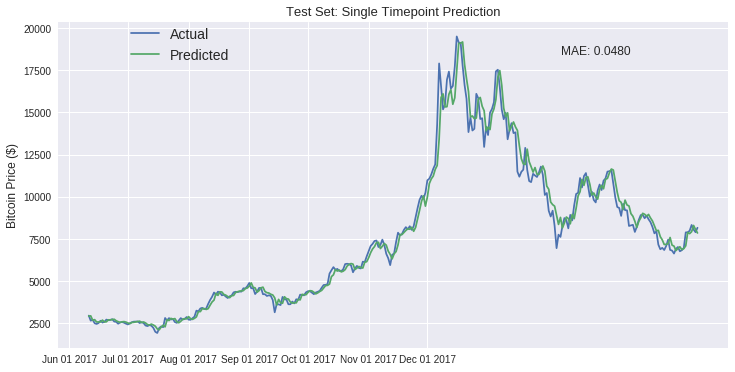

In [50]:
fig, ax1 = plt.subplots(1,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax1.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][10:].astype(datetime.datetime),
         test_set['bt_Close'][window_len:], label='Actual')
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][10:].astype(datetime.datetime),
         ((np.transpose(bt_model.predict(LSTM_test_inputs))+1) * test_set['bt_Close'].values[:-window_len])[0], 
         label='Predicted')
ax1.annotate('MAE: %.4f'%np.mean(np.abs((np.transpose(bt_model.predict(LSTM_test_inputs))+1)-\
            (test_set['bt_Close'].values[window_len:])/(test_set['bt_Close'].values[:-window_len]))), 
             xy=(0.75, 0.9),  xycoords='axes fraction',
            xytext=(0.75, 0.9), textcoords='axes fraction')
ax1.set_title('Test Set: Single Timepoint Prediction',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.1, 1), loc=2, borderaxespad=0., prop={'size': 14})
plt.show()

#  Next 5 day Prediction
As I've stated earlier, single point predictions can be deceptive. Looking more closely, you'll notice that, again, the predicted values regularly mirror the previous values (e.g. October). Our fancy deep learning LSTM model has partially reproducted a [autregressive (AR) model](https://dashee87.github.io/data%20science/general/A-Road-Incident-Model-Analysis/) of some order `p`, where future values are simply the weighted sum of the previous `p` values. We can define an AR model in these mathematical terms:  

\begin{align}
PredPrice_{t} & = \phi_0 + \phi_1*Price_{t-1} + \ldots + \phi_p*Price_{t-p} + \epsilon_t, \ \epsilon_t \sim N(0, \sigma)\
\end{align}

The good news is that AR models are commonly employed in time series tasks (e.g. [stock market prices](https://upcommons.upc.edu/bitstream/handle/2099/3572/04marcek.pdf)), so the LSTM model appears to have landed on a sensible solution. The bad news is that it's a waste of the LSTM capabilities, we could have a built a much simpler AR model in much less time and probably achieved similar results (though the title of this post would have been much less clickbaity). [More complex does not automatically equal more accurate](https://pdfs.semanticscholar.org/696c/2fa5697f58914921ff37d69ced44ddea143f.pdf)). 

We'll now build LSTM models to predict crypto prices for the next 5 days.

In [51]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 5
# initialise model architecture
eth_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['eth_Close'])-pred_range):
    LSTM_training_outputs.append((training_set['eth_Close'][i:i+pred_range].values/
                                  training_set['eth_Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
eth_history = eth_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 4s - loss: 0.2213
Epoch 2/50
 - 4s - loss: 0.1576
Epoch 3/50
 - 4s - loss: 0.1449
Epoch 4/50
 - 4s - loss: 0.1378
Epoch 5/50
 - 4s - loss: 0.1286
Epoch 6/50
 - 4s - loss: 0.1256
Epoch 7/50
 - 4s - loss: 0.1244
Epoch 8/50
 - 4s - loss: 0.1266
Epoch 9/50
 - 4s - loss: 0.1205
Epoch 10/50
 - 4s - loss: 0.1201
Epoch 11/50
 - 4s - loss: 0.1172
Epoch 12/50
 - 4s - loss: 0.1201
Epoch 13/50
 - 4s - loss: 0.1161
Epoch 14/50
 - 4s - loss: 0.1179
Epoch 15/50
 - 4s - loss: 0.1171
Epoch 16/50
 - 4s - loss: 0.1197
Epoch 17/50
 - 4s - loss: 0.1152
Epoch 18/50
 - 4s - loss: 0.1166
Epoch 19/50
 - 4s - loss: 0.1162
Epoch 20/50
 - 4s - loss: 0.1146
Epoch 21/50
 - 4s - loss: 0.1133
Epoch 22/50
 - 4s - loss: 0.1120
Epoch 23/50
 - 4s - loss: 0.1125
Epoch 24/50
 - 4s - loss: 0.1102
Epoch 25/50
 - 4s - loss: 0.1147
Epoch 26/50
 - 4s - loss: 0.1109
Epoch 27/50
 - 4s - loss: 0.1128
Epoch 28/50
 - 4s - loss: 0.1112
Epoch 29/50
 - 4s - loss: 0.1122
Epoch 30/50
 - 4s - loss: 0.1106
Epoch 31/50
 - 4s -

In [52]:
# random seed for reproducibility
np.random.seed(202)
# we'll try to predict the closing price for the next 5 days 
# change this value if you want to make longer/shorter prediction
pred_range = 5
# initialise model architecture
bt_model = build_model(LSTM_training_inputs, output_size=pred_range, neurons = 20)
# model output is next 5 prices normalised to 10th previous closing price
LSTM_training_outputs = []
for i in range(window_len, len(training_set['bt_Close'])-pred_range):
    LSTM_training_outputs.append((training_set['bt_Close'][i:i+pred_range].values/
                                  training_set['bt_Close'].values[i-window_len])-1)
LSTM_training_outputs = np.array(LSTM_training_outputs)
# train model on data
# note: eth_history contains information on the training error per epoch
bt_history = bt_model.fit(LSTM_training_inputs[:-pred_range], LSTM_training_outputs, 
                            epochs=50, batch_size=1, verbose=2, shuffle=True)

Epoch 1/50
 - 4s - loss: 0.1042
Epoch 2/50
 - 4s - loss: 0.0645
Epoch 3/50
 - 4s - loss: 0.0528
Epoch 4/50
 - 4s - loss: 0.0482
Epoch 5/50
 - 4s - loss: 0.0446
Epoch 6/50
 - 4s - loss: 0.0438
Epoch 7/50
 - 4s - loss: 0.0419
Epoch 8/50
 - 4s - loss: 0.0407
Epoch 9/50
 - 4s - loss: 0.0413
Epoch 10/50
 - 4s - loss: 0.0412
Epoch 11/50
 - 4s - loss: 0.0394
Epoch 12/50
 - 4s - loss: 0.0393
Epoch 13/50
 - 4s - loss: 0.0395
Epoch 14/50
 - 4s - loss: 0.0392
Epoch 15/50
 - 4s - loss: 0.0384
Epoch 16/50
 - 4s - loss: 0.0397
Epoch 17/50
 - 4s - loss: 0.0383
Epoch 18/50
 - 4s - loss: 0.0380
Epoch 19/50
 - 4s - loss: 0.0387
Epoch 20/50
 - 4s - loss: 0.0384
Epoch 21/50
 - 4s - loss: 0.0383
Epoch 22/50
 - 4s - loss: 0.0381
Epoch 23/50
 - 4s - loss: 0.0375
Epoch 24/50
 - 4s - loss: 0.0367
Epoch 25/50
 - 4s - loss: 0.0373
Epoch 26/50
 - 4s - loss: 0.0377
Epoch 27/50
 - 4s - loss: 0.0372
Epoch 28/50
 - 4s - loss: 0.0370
Epoch 29/50
 - 4s - loss: 0.0374
Epoch 30/50
 - 4s - loss: 0.0360
Epoch 31/50
 - 4s -

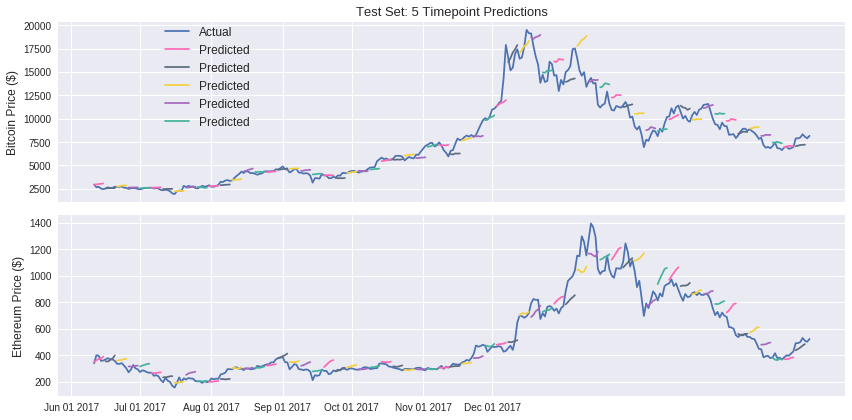

In [53]:
# little bit of reformatting the predictions to closing prices
eth_pred_prices = ((eth_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['eth_Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))
bt_pred_prices = ((bt_model.predict(LSTM_test_inputs)[:-pred_range][::pred_range]+1)*\
                   test_set['bt_Close'].values[:-(window_len + pred_range)][::5].reshape(int(np.ceil((len(LSTM_test_inputs)-pred_range)/float(pred_range))),1))

pred_colors = ["#FF69B4", "#5D6D7E", "#F4D03F","#A569BD","#45B39D"]
fig, (ax1, ax2) = plt.subplots(2,1)
ax1.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticks([datetime.date(2017,i+1,1) for i in range(12)])
ax2.set_xticklabels([datetime.date(2017,i+1,1).strftime('%b %d %Y')  for i in range(12)])
ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['bt_Close'][window_len:], label='Actual')
ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime),
         test_set['eth_Close'][window_len:], label='Actual')
for i, (eth_pred, bt_pred) in enumerate(zip(eth_pred_prices, bt_pred_prices)):
    # Only adding lines to the legend once
    if i<5:
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%5], label="Predicted")
    else: 
        ax1.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
                 bt_pred, color=pred_colors[i%5])
    ax2.plot(model_data[model_data['Date']>= split_date]['Date'][window_len:].astype(datetime.datetime)[i*pred_range:i*pred_range+pred_range],
             eth_pred, color=pred_colors[i%5])
ax1.set_title('Test Set: 5 Timepoint Predictions',fontsize=13)
ax1.set_ylabel('Bitcoin Price ($)',fontsize=12)
ax1.set_xticklabels('')
ax2.set_ylabel('Ethereum Price ($)',fontsize=12)
ax1.legend(bbox_to_anchor=(0.13, 1), loc=2, borderaxespad=0., prop={'size': 12})
fig.tight_layout()
plt.show()

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [55]:
!ls -al

total 48
drwxr-xr-x 1 root root 4096 Apr 20 01:04 .
drwxr-xr-x 1 root root 4096 Apr 19 19:47 ..
drwx------ 4 root root 4096 Apr 20 00:16 .cache
drwxr-xr-x 3 root root 4096 Apr 20 00:16 .config
drwxr-xr-x 1 root root 4096 Apr 20 00:18 datalab
drwxr-xr-x 2 root root 4096 Apr 20 01:04 drive
drwxr-xr-x 4 root root 4096 Apr 19 19:48 .forever
drwx------ 3 root root 4096 Apr 20 00:18 .gdfuse
drwxr-xr-x 5 root root 4096 Apr 20 00:16 .ipython
drwxr-xr-x 2 root root 4096 Apr 20 00:38 .keras
drwx------ 3 root root 4096 Apr 19 19:48 .local
-rw------- 1 root root 1024 Apr 19 19:48 .rnd


In [0]:
import os
os.chdir("drive/app")

In [0]:
os.chdir("alt_futures")

#  25 RANDOM Seeds

The predictions are visibly less impressive than their single point counterparts. Nevertheless, I'm pleased that the model returned somewhat nuanced behaviours (e.g. the second line on the eth graph); it didn't simply forecast prices to move uniformly in one direction. So there are some grounds for optimism.

Moving back to the single point predictions, our deep machine artificial neural model looks okay, but so did that boring random walk model. Like the random walk model, LSTM models can be sensitive to the choice of random seed (the model weights are initially randomly assigned). So, if we want to compare the two models, we'll run each one multiple (say, 25) times to get an estimate for the model error. The error will be calculated as the absolute difference between the actual and predicted closing prices changes in the test set.

In [0]:

!rm  models/*

In [59]:
# warning: this cell may take some time to execute
# this code builds 25 LSTM models for eth and bitcoin each (with 25 different initialisations)
# the models are then saved so you hopefully only need to run this cell once

# random seed for reproducibility
for rand_seed in range(775,800):
    print(rand_seed)
    np.random.seed(rand_seed)
    temp_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
    temp_model.fit(LSTM_training_inputs,
                   (training_set['eth_Close'][window_len:].values/training_set['eth_Close'][:-window_len].values)-1,
                 epochs=50, batch_size=1, verbose=0, shuffle=True)
    temp_model.save('models/eth_model_randseed_%d.h5'%rand_seed)
    
    
    temp_model = build_model(LSTM_training_inputs, output_size=1, neurons = 20)
    temp_model.fit(LSTM_training_inputs,
    (training_set['bt_Close'][window_len:].values/training_set['bt_Close'][:-window_len].values)-1,
                   epochs=50, batch_size=1, verbose=0, shuffle=True)
    temp_model.save('models/bt_model_randseed_%d.h5'%rand_seed)
    


775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799


#  Models saved locally

In [60]:

!ls -al models


total 2658
drwxr-xr-x 2 root root  4096 Mar 27 05:48 .
drwxr-xr-x 2 root root  4096 Mar 27 04:54 ..
-rw-r--r-- 1 root root 53888 Apr 20 01:11 bt_model_randseed_775.h5
-rw-r--r-- 1 root root 53888 Apr 20 01:18 bt_model_randseed_776.h5
-rw-r--r-- 1 root root 53904 Apr 20 01:25 bt_model_randseed_777.h5
-rw-r--r-- 1 root root 53920 Apr 20 01:31 bt_model_randseed_778.h5
-rw-r--r-- 1 root root 53920 Apr 20 01:37 bt_model_randseed_779.h5
-rw-r--r-- 1 root root 53920 Apr 20 01:43 bt_model_randseed_780.h5
-rw-r--r-- 1 root root 53920 Apr 20 01:49 bt_model_randseed_781.h5
-rw-r--r-- 1 root root 53920 Apr 20 01:56 bt_model_randseed_782.h5
-rw-r--r-- 1 root root 53920 Apr 20 02:03 bt_model_randseed_783.h5
-rw-r--r-- 1 root root 53920 Apr 20 02:09 bt_model_randseed_784.h5
-rw-r--r-- 1 root root 53920 Apr 20 02:16 bt_model_randseed_785.h5
-rw-r--r-- 1 root root 53920 Apr 20 02:23 bt_model_randseed_786.h5
-rw-r--r-- 1 root root 53920 Apr 20 02:30 bt_model_randseed_787.h5
-rw-r--r-- 1 root root 53920 

In [0]:
from keras.models import load_model
temp_bt_model_file = h5py.File('models/bt_model_randseed_799.h5')
temp_bt_model = load_model('models/bt_model_randseed_799.h5')

In [62]:
temp_bt_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_54 (LSTM)               (None, 20)                2320      
_________________________________________________________________
dropout_54 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_54 (Dense)             (None, 1)                 21        
_________________________________________________________________
activation_54 (Activation)   (None, 1)                 0         
Total params: 2,341
Trainable params: 2,341
Non-trainable params: 0
_________________________________________________________________


In [0]:
from keras.models import load_model
temp_eth_model_file = h5py.File('models/eth_model_randseed_799.h5')
temp_eth_model = load_model('models/eth_model_randseed_799.h5')

In [64]:
temp_eth_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_53 (LSTM)               (None, 20)                2320      
_________________________________________________________________
dropout_53 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_53 (Dense)             (None, 1)                 21        
_________________________________________________________________
activation_53 (Activation)   (None, 1)                 0         
Total params: 2,341
Trainable params: 2,341
Non-trainable params: 0
_________________________________________________________________


# Average MAE Across seeds

In [0]:
# assuming the previous cell was completed, this cell loads in the different initialisations
# and calculates the average mean absolute error (mae)

from keras.models import load_model

eth_preds = []
bt_preds = []
for rand_seed in range(775,800):
    temp_model = load_model('models/eth_model_randseed_%d.h5'%rand_seed)
    eth_preds.append(np.mean(abs(np.transpose(temp_model.predict(LSTM_test_inputs))-
                (test_set['eth_Close'].values[window_len:]/test_set['eth_Close'].values[:-window_len]-1))))
    temp_model = load_model('models/bt_model_randseed_%d.h5'%rand_seed)
    bt_preds.append(np.mean(abs(np.transpose(temp_model.predict(LSTM_test_inputs))-
                (test_set['bt_Close'].values[window_len:]/test_set['bt_Close'].values[:-window_len]-1))))

In [0]:
eth_random_walk_preds = []
bt_random_walk_preds = []
for rand_seed in range(775,800):
    np.random.seed(rand_seed)
    eth_random_walk_preds.append(
        np.mean(np.abs((np.random.normal(eth_r_walk_mean, eth_r_walk_sd, len(test_set)-window_len)+1)-
                       np.array(test_set['eth_Close'][window_len:])/np.array(test_set['eth_Close'][:-window_len]))))
    bt_random_walk_preds.append(
    np.mean(np.abs((np.random.normal(bt_r_walk_mean, bt_r_walk_sd, len(test_set)-window_len)+1)-
                       np.array(test_set['bt_Close'][window_len:])/np.array(test_set['bt_Close'][:-window_len]))))

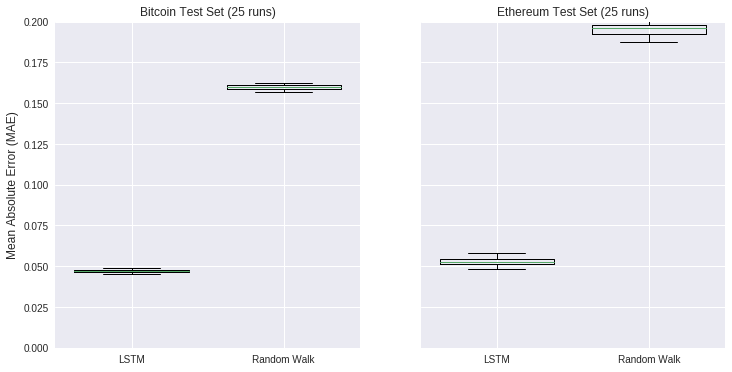

In [67]:
fig, (ax1, ax2) = plt.subplots(1,2)
ax1.boxplot([bt_preds, bt_random_walk_preds],widths=0.75)
ax1.set_ylim([0, 0.2])
ax2.boxplot([eth_preds, eth_random_walk_preds],widths=0.75)
ax2.set_ylim([0, 0.2])
ax1.set_xticklabels(['LSTM', 'Random Walk'])
ax2.set_xticklabels(['LSTM', 'Random Walk'])
ax1.set_title('Bitcoin Test Set (25 runs)')
ax2.set_title('Ethereum Test Set (25 runs)')
ax2.set_yticklabels('')
ax1.set_ylabel('Mean Absolute Error (MAE)',fontsize=12)
plt.show()

Maybe AI is worth the hype after all! Those graphs show the error on the test set after 25 different initialisations of each model. The LSTM model returns an average error of about 0.04 and 0.05 on the bitcoin and eth prices, respectively, crushing the corresponding random walk models.

Aiming to beat random walks is a pretty low bar. It would be more interesting to compare the LSTM model against more appropriate time series models (weighted average, autoregression, [ARIMA](https://dashee87.github.io/data%20science/general/A-Road-Incident-Model-Analysis/) or Facebook's [Prophet algorithm](https://github.com/facebook/prophet)). On the other hand, I'm sure it wouldn't be hard to improve our LSTM model (gratuitously adding more layers and/or neurons, changing the batch size, learning rate, etc.). That said, hopefully you've detected my scepticism when it comes to applying deep learning to predict changes in crypto prices. That's because we're overlooking the best framework of all: human intelligence. Clearly, the perfect model* for predicting cryptos is:

\begin{align}
& Price^{Crypto}_{t} > Price^{Crypto}_{t-1} \,  \forall \ Crypto \neq OmiseGo \textrm{, }  \\
& \textrm{  where } Price^{Crypto}_{t} \to moon \textrm{, as } t \to    \infty           
\end{align}

&#42; This blog does not constitute financial advice and should not be taken as such. While cryptocurrency investments will definitely go up in value forever, they may also go down.

# Summary

Collected some crypto data and fed it into a deeply intelligent machine learning LSTM model. Unfortunately, its predictions were not that different from just spitting out the previous value. How can we make the model learn more sophisticated behaviours?

* **Change Loss Function**: MAE doesn't really encourage risk taking. For example, under mean squared error (MSE), the LSTM model would be forced to place more importance on detecting spikes/troughs. [More bespoke trading focused loss functions](http://www.faculty.ucr.edu/~taelee/paper/lossfunctions.pdf) could also move the model towards less conservative behaviours.

* **Penalise conservative AR-type models**: This would incentivise the deep learning algorithm to explore more risky/interesting models. Easier said than done!

* **Get more and/or better data**: If past prices alone are sufficient to decently forecast future prices, we need to include other features that provide comparable predictive power. That way, the LSTM model wouldn't be so reliant on past prices, potentially unlocking more complex behaviours. This is probably the best and hardest solution.

It is entirely possible that there is no detectable pattern to changes in crypto prices; that no model (however deep) can separate the signal from the noise (similar to the merits of using [deep learning to predict earthquakes](https://www.scientificamerican.com/article/can-artificial-intelligence-predict-earthquakes/)). And any pattern that does appear [can disappear as quickly](http://site.iugaza.edu.ps/wdaya/files/2013/03/A-Random-Walk-Down-Wall-Street.pdf) (see [efficient market hypothesis](results_merge.click2)). 

Just think how different Bitcoin in 2016 is to craze-riding Bitcoin of late 2017. Any model built on 2016 data would surely struggle to replicate these unprecedented movements. All of this suggests you might as well save yourself some time and stick to autoregression (unless you're writing a blog, of course).

